In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import linalg
from scipy.sparse.linalg import eigs
import scipy.optimize
import numpy as np
from sklearn.linear_model import LinearRegression
import math

In [2]:
# all the files '.csv' (generated in CountryAssetsCountry) for each year are grouped in a single dataframe called dataAssets
# all the files '.csv' (generated in Final_cleaning_data) for each year are grouped in a single dataframe called dataTrade
 
dataAssets = []
dataTrade = []

for i in range(2001, 2020):
    dataFrame = pd.read_csv('allyearsasset' +str(i)+ '.csv')
    dataFrame = dataFrame[['target','source','asset value']]
    dataAssets.append(dataFrame)

for i in range(2001, 2020):
    dataFrame = pd.read_csv('allyearstrade' +str(i)+ '.csv')
    dataFrame = dataFrame[['country','partner','flow']]
    dataTrade.append(dataFrame)


In [3]:
def graph(year):  # this function generates assets and trade graphs
    
    dfa = dataAssets[year-2001]  # dataframe assets
    dft = dataTrade[year-2001]  # dataframe trade
    
    keysa = dfa.keys()
    keyst = dft.keys()

    dfkey0a = dfa[keysa[0]]  # target column for assets
    dfkey0a = set(dfkey0a)   # used to delete the repeated elements
    dfkey1a = dfa[keysa[1]]  # source column for assets
    dfkey1a = set(dfkey1a)  

    dfkey0t = dft[keyst[0]]  # country column for trade (coutry that exports (sends money))
    dfkey0t = set(dfkey0t) 
    dfkey1t = dft[keyst[1]]  # partner column for trade (coutry that imports (receives money))
    dfkey1t = set(dfkey1t)  

    nodesa = dfkey0a.union(dfkey1a)
    nodesa = set(nodesa) 
    nodesa = sorted(nodesa) 
    nodesa = list(nodesa)  # nodes in assets graph

    nodest = dfkey0t.union(dfkey1t)
    nodest = set(nodest) 
    nodest = sorted(nodest) 
    nodest = list(nodest)  # nodes in trade graph

    AG = nx.DiGraph()  # ASSESTS GRAPH
    AG.add_nodes_from(nodesa) 
    (lar,lac) = dfa.shape
    la = lar

    TG = nx.DiGraph()  # TRADE GRAPH
    TG.add_nodes_from(nodest) 
    (ltr,ltc) = dft.shape
    lt = ltr

    for i in range(0,la):
        rowa = dfa.loc[i]    # select row i from dataframe
        row1 = rowa[0]       # exchange positions as function is edges(from_, to_,weight)
        row2 = rowa[1]
        row3 = rowa[2]
        AG.add_weighted_edges_from([(row2,row1,row3)])

    for i in range(0,lt):
        rowt = dft.loc[i]
        TG.add_weighted_edges_from([(rowt)])

        
    return AG, TG, nodesa, nodest

In [4]:
assetsgraph, tradegraph, nodesa,nodest = graph(2017) # example

In [5]:
def distr_bin(data, n_bin=10, logbin=False): # Michele's function (bins)
    """ Logarithmic binning of raw positive data;
        Input:
            data = np array,
            bins= number if bins,
            logbin = if true log bin
        Output (array: bins, array: hist)
        bins: centred bins
        hist: histogram value / (bin_length*num_el_data) [nonzero]
    """
    if len(data)==0:
        print ('Error empty data\n')
    min_d = float(min(data))
    if logbin and min_d<=0:
        print ('Error nonpositive data\n')
    #print ‘min: ’, min(data), ‘max: ’, float(max(data))
    n_bin = float(n_bin)            #ensure float values
    bins = np.arange(n_bin+1)
    if logbin:
        data = np.array(data)/min_d
        base= np.power(float(max(data)) , 1.0/n_bin)
        bins = np.power(base,bins)
        bins = np.ceil(bins)                   #to avoid problem for small ints
    else:
        data = np.array(data) + min_d          #to include negative data
        delta = (float(max(data)) - float(min(data)))/n_bin
        bins = bins*delta + float(min(data))
    #print ‘first bin: ’, bins[0], ‘first data:’, min(data), ‘max bin:’, bins[n_bin], ‘max data’, float(max(data))
    #for b in bins:
    #    print b
    bins[0]     = float(min(data))                       #fix the minimun and max
    #bins[n_bin] = float(max(data))
    hist = np.histogram(data, bins)[0]
    #print ‘[], hist with zeros:’
    #for i in range(len(bins)-1):
    #    print bins[i], bins[i+1], hist[i]
    ii = np.nonzero(hist)[0]            #take non zero values of histogram
    bins = bins[ii]
    hist = hist[ii]
    bins=np.append(bins,float(max(data)))          #append the last bin (why??)
    #print ‘[    ], hist:’                         #missin /min_d or -min_d
    #for i in range(len(bins)-1):
    #    if logbin:
    #        print bins[i]*min_d, bins[i+1]*min_d, hist[i]
    #    else:
    #       print bins[i]-min_d, bins[i+1]-min_d, hist[i]
    bin_len = np.diff(bins)
    bins =  bins[:-1] + bin_len/2.0     #don’t return last bin, centred boxes
    if logbin:
        hist = hist/bin_len                 #normalize values
        bins = bins*min_d                   #restore original bin values
    else:
        bins = bins - min_d
    return zip(bins, hist/float(sum(hist)))    #restore original bin values, norm hist
#end function


In [6]:
def plotpdf(year): # this function plots the pdf for the imported assets (in Assets), exported assets(out Assets), 
                   # imported trade (in trade) and exported trade (out trade) for each year in a logarithmic scale.
                   # the red line is a linear regression of the set of points
    
    assetsgraph, tradegraph, nodesa, nodest = graph(year)
    arrayka = np.array([])
    arraykain = np.array([])
    arraykt = np.array([])
    arrayktin = np.array([])
    figure, axis = plt.subplots(1, 4,figsize=(10, 3))
        
    for node in nodesa:
        ka = assetsgraph.out_degree(node) 
        arrayka = np.append(arrayka,ka)
        arrayka = arrayka[arrayka!=0]
        kain = assetsgraph.in_degree(node) 
        arraykain = np.append(arraykain,kain)
        arraykain = arraykain[arraykain!=0]

    for node in nodest:
        kt = tradegraph.out_degree(node)
        arraykt = np.append(arraykt,kt)
        arraykt = arraykt[arraykt!=0]
        ktin = tradegraph.in_degree(node)
        arrayktin = np.append(arrayktin,ktin)
        arrayktin = arrayktin[arrayktin!=0]
        
    arrayka = list(arrayka)
    arraykain = list(arraykain)
    arraykt = list(arraykt)
    arrayktin = list(arrayktin)
    degreepdfa = distr_bin(arrayka, n_bin=20, logbin=True)
    degreepdfain = distr_bin(arraykain, n_bin=20, logbin=True)
    degreepdft = distr_bin(arraykt, n_bin=20, logbin=True)
    degreepdftin = distr_bin(arraykt, n_bin=20, logbin=True)
        
    arrayvalbina = np.array([])     #  out assets
    arrayprobbina = np.array([])
    degreepdfa = list(degreepdfa)
    lena = len(degreepdfa)
    
    for i in range(0,lena):
        bininfoa = degreepdfa[i]
        valbina = bininfoa[0]
        probbina = bininfoa[1]
        arrayvalbina = np.append(arrayvalbina,valbina)
        arrayprobbina = np.append(arrayprobbina,probbina)

    arrayvalbinain = np.array([])    #   in assets
    arrayprobbinain = np.array([])
    degreepdfain = list(degreepdfain)
    lenain = len(degreepdfain)
    
    for i in range(0,lenain):
        bininfoain = degreepdfain[i]
        valbinain = bininfoain[0]
        probbinain = bininfoain[1]
        arrayvalbinain = np.append(arrayvalbinain,valbinain)
        arrayprobbinain = np.append(arrayprobbinain,probbinain)

    arrayvalbint = np.array([])    #   out trade
    arrayprobbint = np.array([])
    degreepdft = list(degreepdft)
    lent = len(degreepdft)
    
    for i in range(0,lent):
        bininfot = degreepdft[i]
        valbint = bininfot[0]
        probbint = bininfot[1]
        arrayvalbint = np.append(arrayvalbint,valbint)
        arrayprobbint = np.append(arrayprobbint,probbint) 

    arrayvalbintin = np.array([]) # in trade
    arrayprobbintin = np.array([])
    degreepdftin = list(degreepdftin)
    lentin = len(degreepdftin)
    
    for i in range(0,lentin):
        bininfotin = degreepdftin[i]
        valbintin = bininfotin[0]
        probbintin = bininfotin[1]
        arrayvalbintin = np.append(arrayvalbintin,valbintin)
        arrayprobbintin = np.append(arrayprobbintin,probbintin) 

    axis[0].scatter(arrayvalbinain,arrayprobbinain)
    xexpin = np.log(arrayvalbinain)     #LINEAR REGRESSION IN LOGLOG SCALE
    yexpin = np.log(arrayprobbinain)
    model = LinearRegression()
    model.fit(xexpin.reshape(-1, 1), yexpin)
    y_predin = model.predict(xexpin.reshape(-1, 1))
    y_predin = np.exp(y_predin)
    axis[0].plot(arrayvalbinain, y_predin, color='red', label='Regresión Lineal')
    axis[0].set_title('In Assets')
    axis[0].set_xscale('log')
    axis[0].set_yscale('log')
    axis[0].set_xlabel('k')
    axis[0].set_ylabel('P(k)')    

    axis[1].scatter(arrayvalbina,arrayprobbina)
    xexp = np.log(arrayvalbina)     #LINEAR REGRESSION IN LOGLOG SCALE
    yexp = np.log(arrayprobbina)
    model = LinearRegression()
    model.fit(xexp.reshape(-1, 1), yexp)
    y_pred = model.predict(xexp.reshape(-1, 1))
    y_pred = np.exp(y_pred)
    axis[1].plot(arrayvalbina, y_pred, color='red', label='Regresión Lineal')
    axis[1].set_title('Out Assets')
    axis[1].set_xscale('log')
    axis[1].set_yscale('log')

    axis[2].scatter(arrayvalbintin,arrayprobbintin)
    xexptin = np.log(arrayvalbintin)
    yexptin = np.log(arrayprobbintin)
    model = LinearRegression()
    model.fit(xexptin.reshape(-1, 1), yexptin)
    y_predtin = model.predict(xexptin.reshape(-1, 1))
    y_predtin = np.exp(y_predtin)
    axis[2].plot(arrayvalbintin, y_predtin, color='red', label='Regresión Lineal')
    axis[2].set_title('In Trade')
    axis[2].set_xscale('log')
    axis[2].set_yscale('log')
    
    axis[3].scatter(arrayvalbint,arrayprobbint)
    xexpt = np.log(arrayvalbint)
    yexpt = np.log(arrayprobbint)
    model = LinearRegression()
    model.fit(xexpt.reshape(-1, 1), yexpt)
    y_predt = model.predict(xexpt.reshape(-1, 1))
    y_predt = np.exp(y_predt)
    axis[3].plot(arrayvalbint, y_predt, color='red', label='Regresión Lineal')
    axis[3].set_title('Out Trade')
    axis[3].set_xscale('log')
    axis[3].set_yscale('log')

    plt.suptitle(year, fontsize=16)
    plt.show()



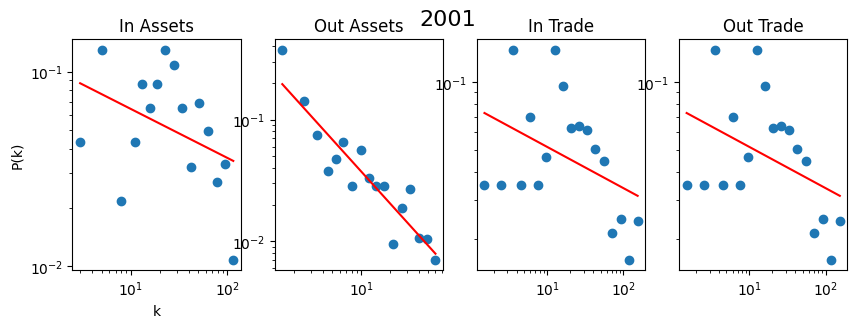

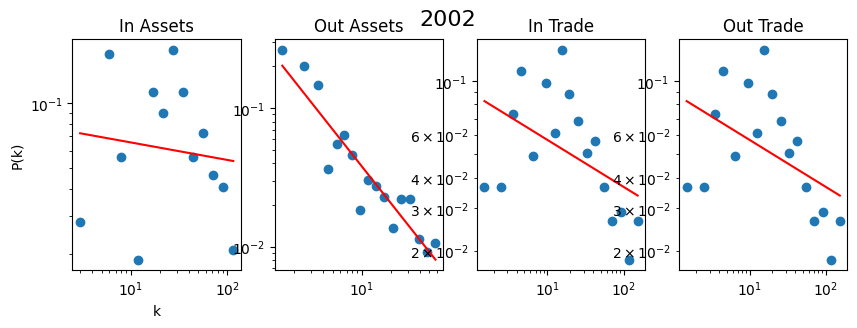

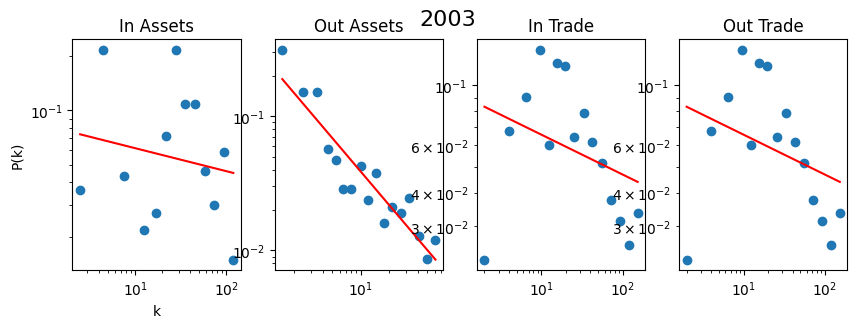

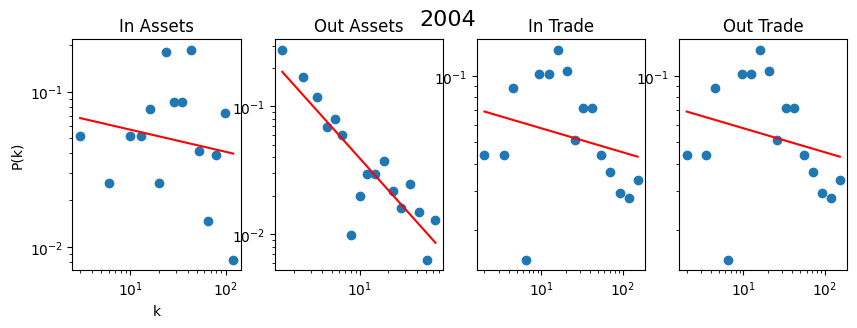

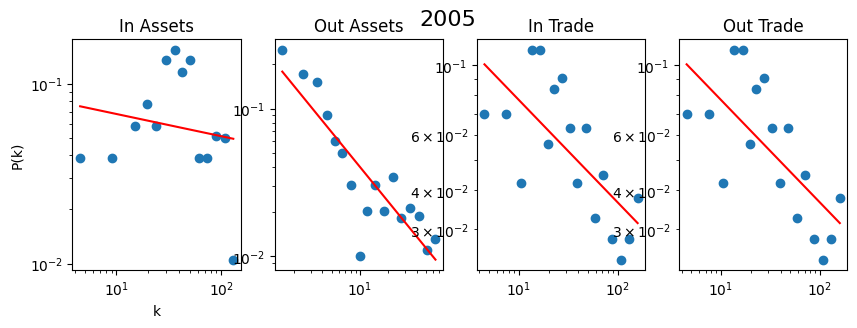

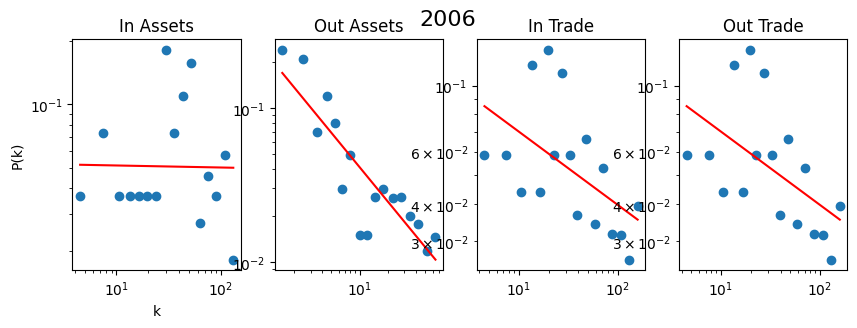

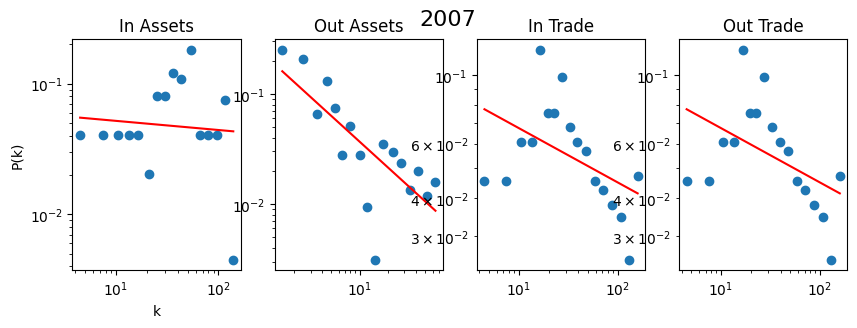

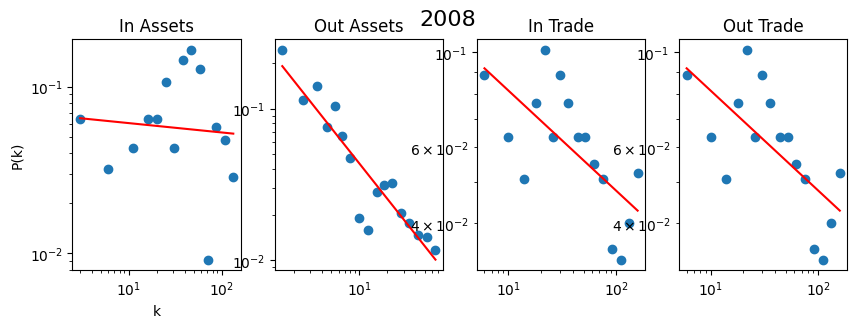

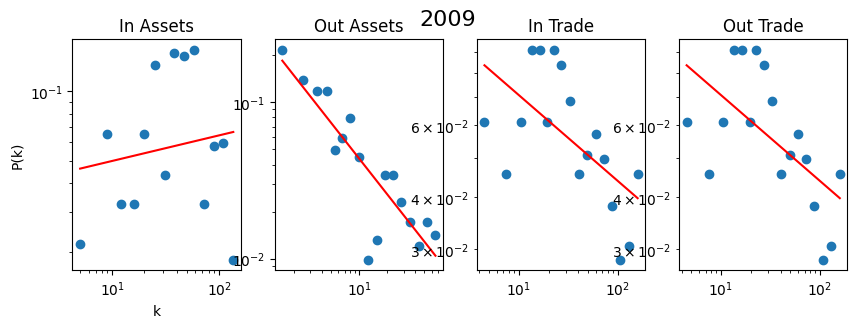

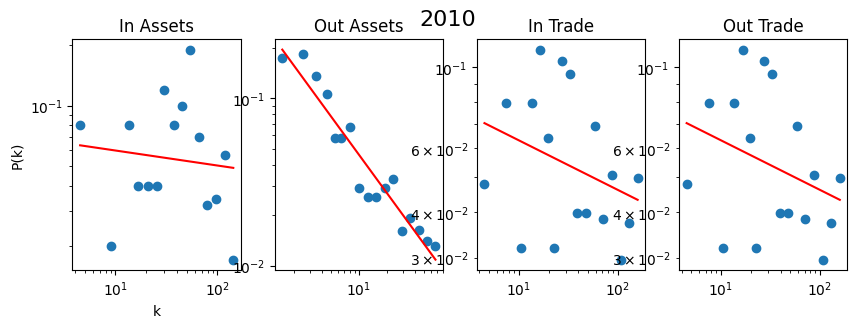

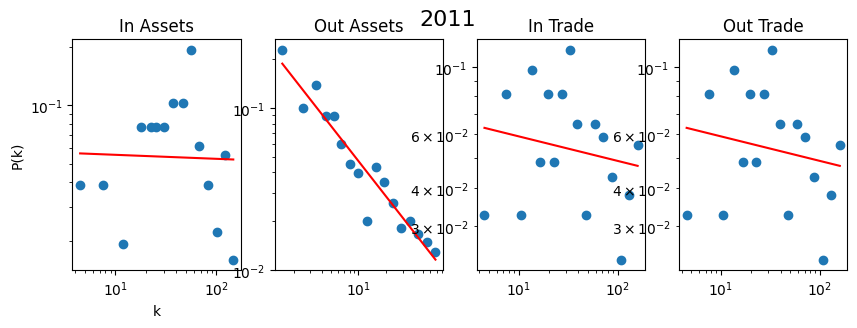

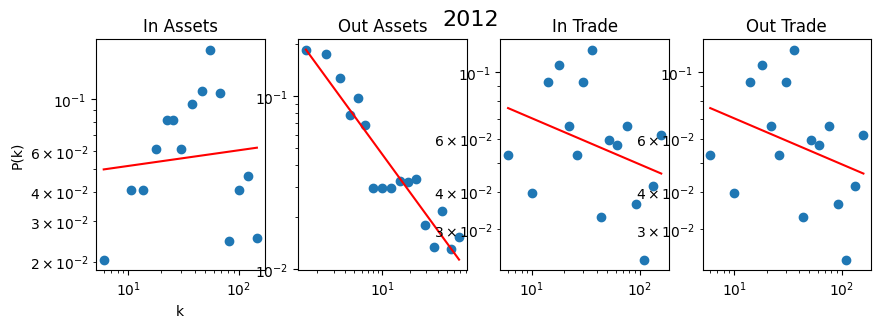

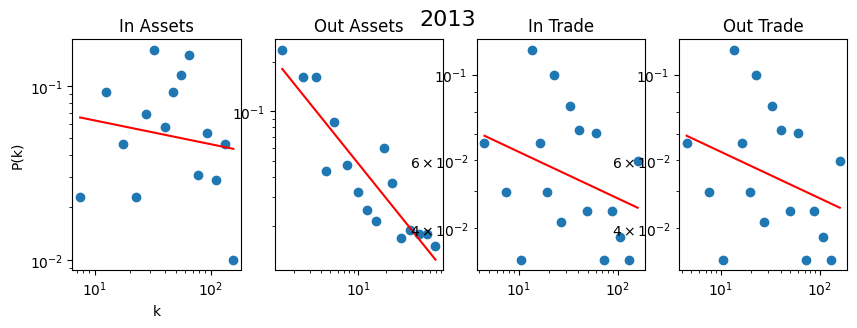

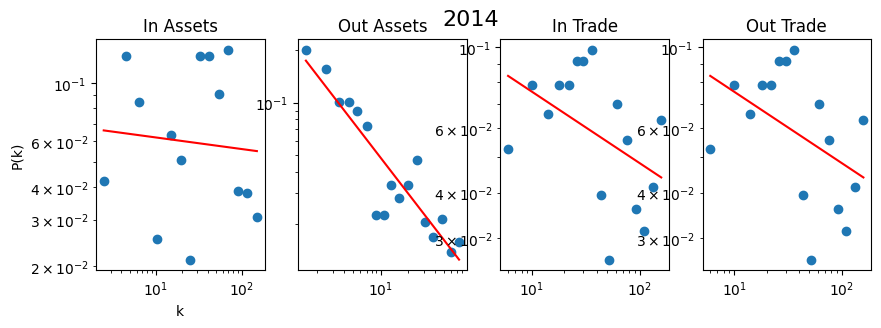

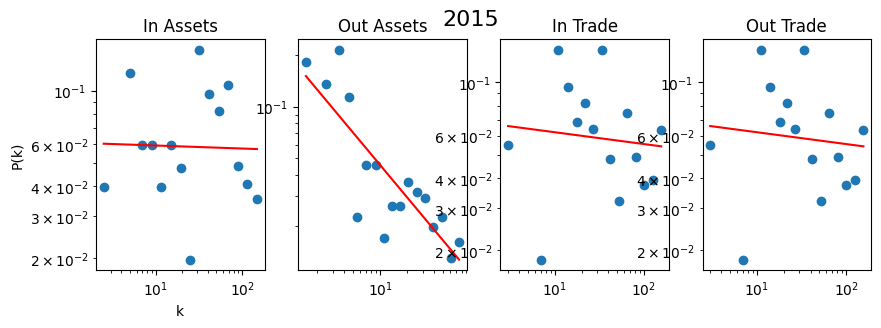

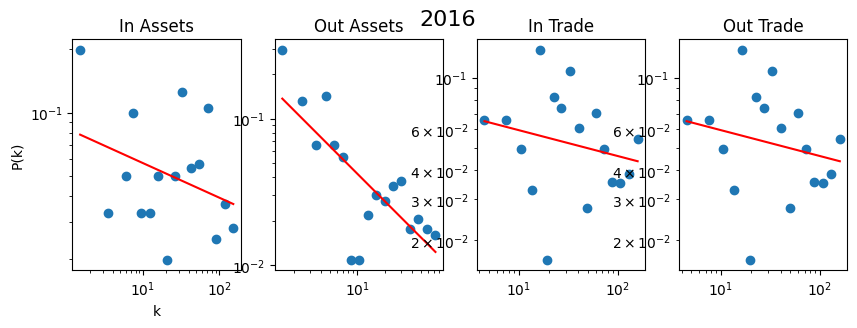

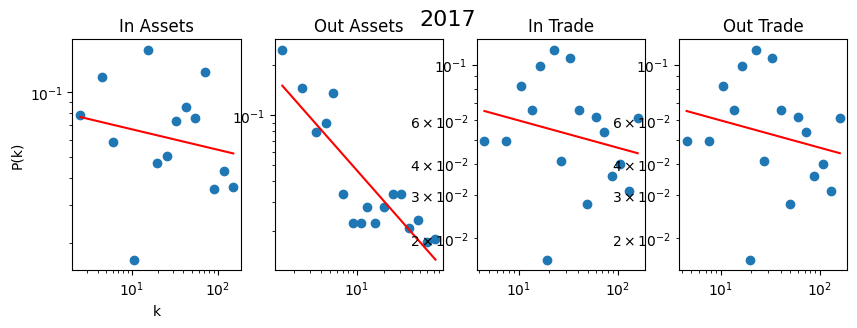

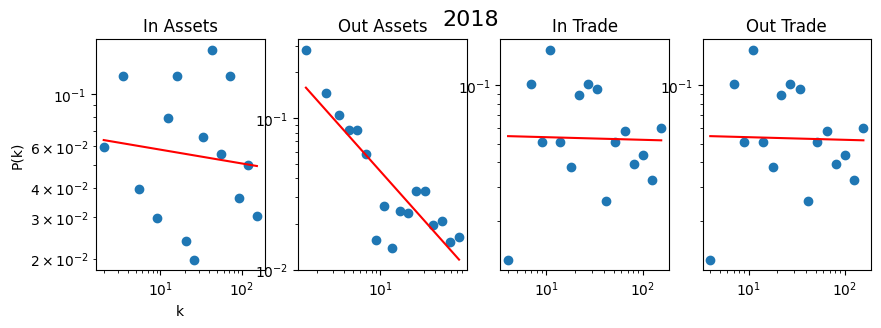

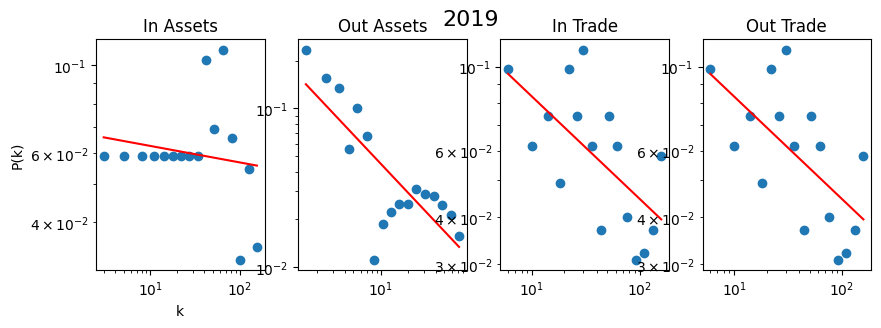

In [154]:
for year in range(2001,2020):
    plotpdf(year)

# only in the 'out Assets' case is satisfied a linear relation (in logarithmic scale)

C:\Users\didac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


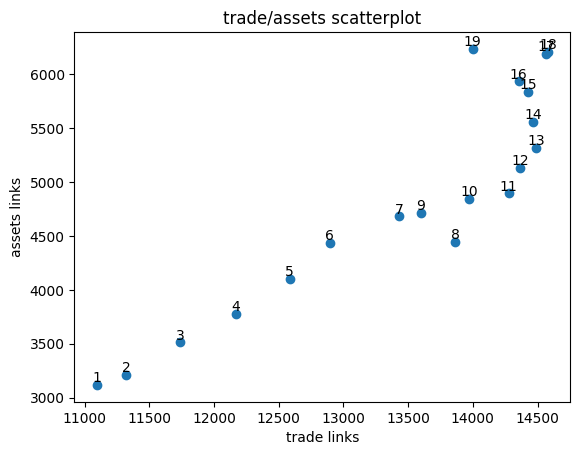

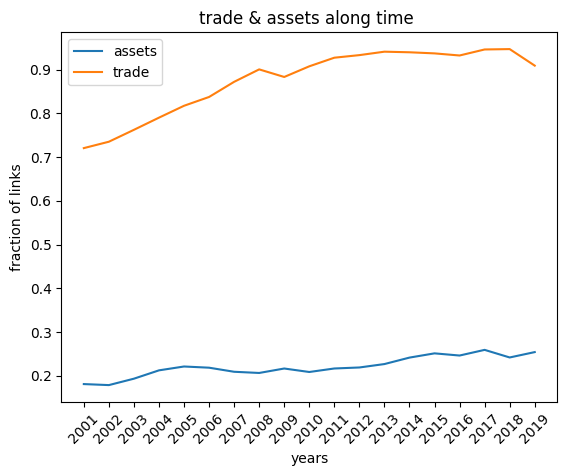

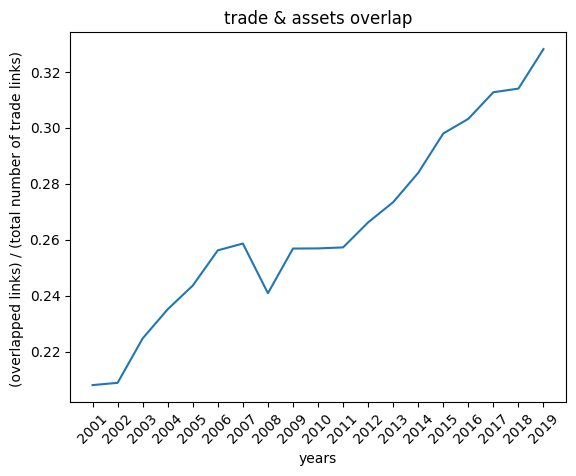

C:\Users\didac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


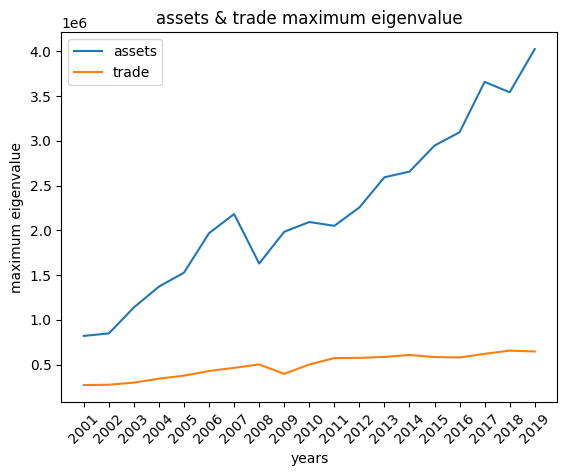

In [7]:


arraydega = np.array([])
arraydegt = np.array([])
arrayedgea = np.array([])
arrayedget = np.array([])
overlaparray = np.array([])
arreiga = np.array([])
arreigt = np.array([])

for year in range(2001,2020):
    assetsgraph, tradegraph, nodesa, nodest = graph(year)

    # MAXIMUM EIGENVALUE 
    mata = nx.adjacency_matrix(assetsgraph) 
    mata = mata.toarray()
    dima = len(mata)
    valsa, vecsa = eigs(mata, k= dima-1)
    eiga = max(valsa)
    arreiga = np.append(arreiga,eiga)
    matt = nx.adjacency_matrix(tradegraph)
    matt = matt.toarray()
    dimt = len(matt)
    valst, vecst = eigs(matt, k= dimt)
    eigt = max(valst)
    arreigt = np.append(arreigt,eigt)
    
    na = len(nodesa)
    nt = len(nodest)

    # FRACTION OF LINKS
    totnuma = na*(na-1)/2  # total number of possible links
    dega = assetsgraph.number_of_edges()
    degan = dega/totnuma # the 'n' means normalized
    arraydega = np.append(arraydega,degan)  # TRADE & ASSETS SCATTERPLOT
    totnumt = nt*(nt-1)/2
    degt = tradegraph.number_of_edges()
    degtn = degt/totnumt
    arraydegt = np.append(arraydegt,degtn) 

    arrayedgea = np.append(arrayedgea,dega)
    arrayedget = np.append(arrayedget,degt)

    #OVERLAP --> number of common links of assets & trade along years
    assetslist = assetsgraph.edges()
    tradelist = tradegraph.edges()
    olaplist = [x for x in assetslist if x in tradelist]
    numoverlap = len(olaplist)/len(tradelist) # tradeist always has more links than assets
    overlaparray = np.append(overlaparray,numoverlap)

plt.scatter(arrayedget,arrayedgea)
plt.xlabel('trade links')
plt.ylabel('assets links')
plt.title('trade/assets scatterplot')

for i in range(len(arrayedget)):
    plt.text(arrayedget[i], arrayedgea[i], f'{i+1}', ha='center', va='bottom') #numerar los puntos, cada numero representa el año
plt.show()

alongt = list(range(2001,2020))
plt.plot(alongt,arraydega,label = 'assets')
plt.plot(alongt,arraydegt,label = 'trade')
plt.xticks(alongt, rotation=45)
plt.xlabel('years')
plt.ylabel('fraction of links')
plt.title('trade & assets along time ')
plt.legend()
plt.show()

plt.plot(alongt,overlaparray)
plt.xticks(alongt, rotation=45)
plt.xlabel('years')
plt.ylabel('(overlapped links) / (total number of trade links) ')
plt.title('trade & assets overlap')
plt.show()

plt.plot(alongt,arreiga,label= 'assets')
plt.plot(alongt,arreigt,label= 'trade')
plt.xticks(alongt, rotation=45)
plt.xlabel('years')
plt.ylabel('maximum eigenvalue')
plt.title('assets & trade maximum eigenvalue')
plt.legend()
plt.show()





In [17]:
# this function plots the in degree and out degree for each node for the assets and trade graphs

def inoutscatter(year): 
    assetsgraph, tradegraph, nodesa,nodest = graph(year)
    
    arraydega = np.array([])
    arraydegt = np.array([])
    figure, axis = plt.subplots(1, 2,figsize=(10, 4))
    
    for node in nodesa:
        indega = assetsgraph.in_degree(node)
        outdega = assetsgraph.out_degree(node)
        arraydega = np.append(indega,outdega)
        axis[0].scatter(indega,outdega,color='blue')   

    axis[0].set_title('Assets')
    axis[0].set_xlabel('in_degree')
    axis[0].set_ylabel('out_degree')
    
    for node in nodest:
        indegt = tradegraph.in_degree(node)
        outdegt = tradegraph.out_degree(node)
        arraydegt = np.append(indegt,outdegt)
        axis[1].scatter(indegt,outdegt,color='blue') 

    xpoints = [0, 175]
    ypoints = [0, 175]
    axis[1].plot(xpoints,ypoints)
    axis[1].set_title('Trade')
    axis[1].set_xlabel('in_degree')
    axis[1].set_ylabel('out_degree')

    plt.suptitle(year, fontsize=16)

    

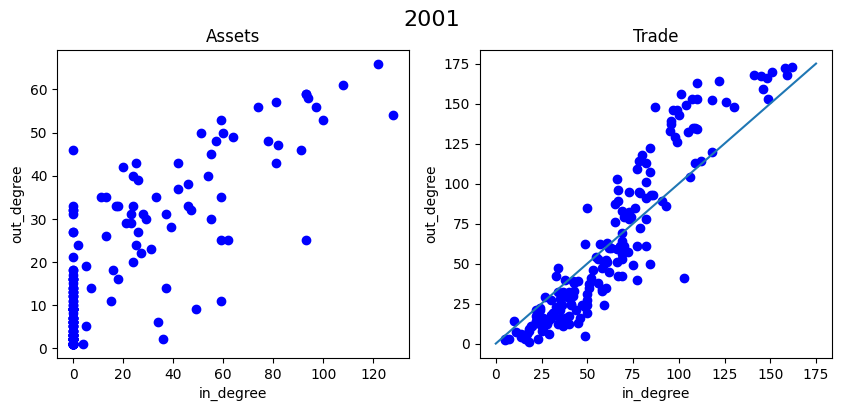

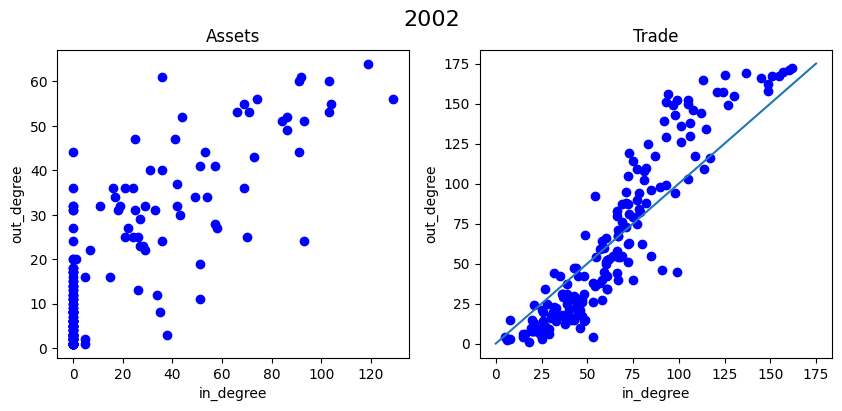

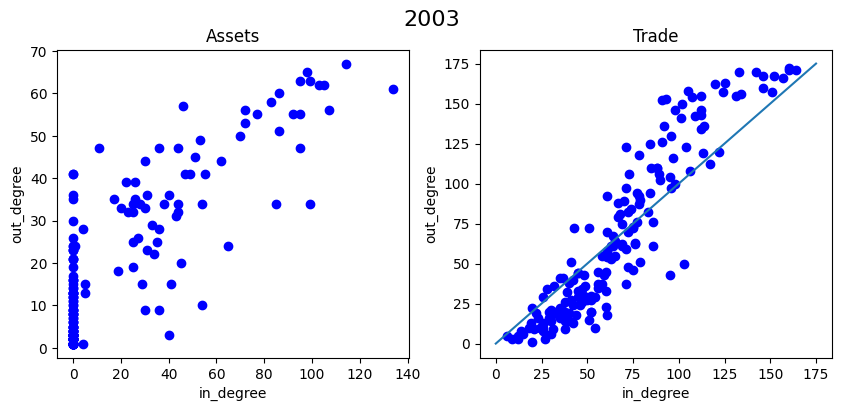

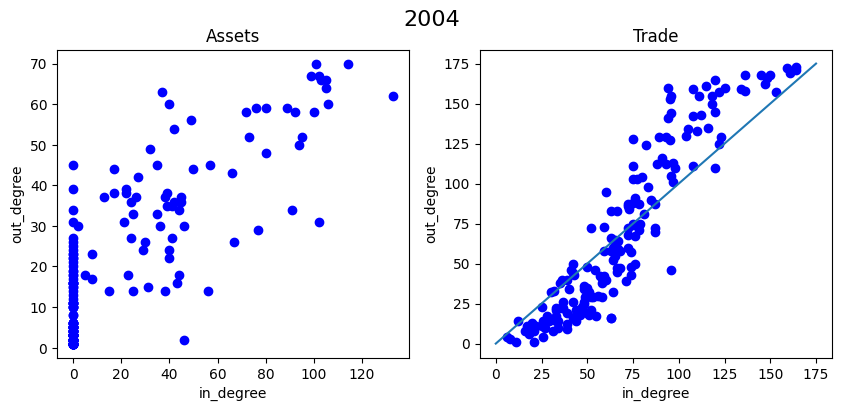

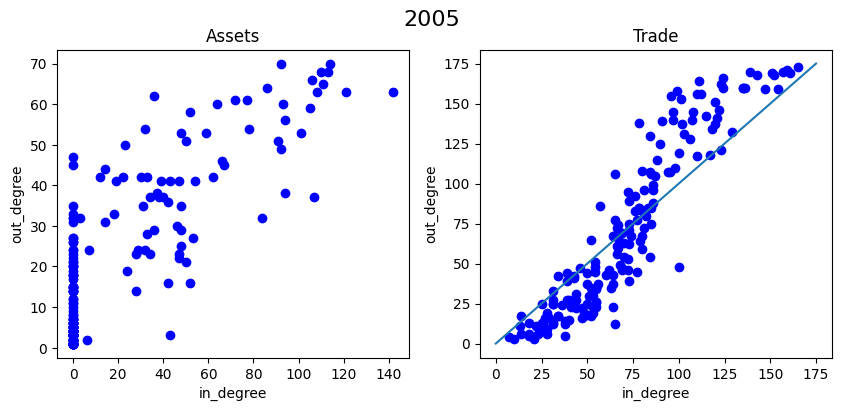

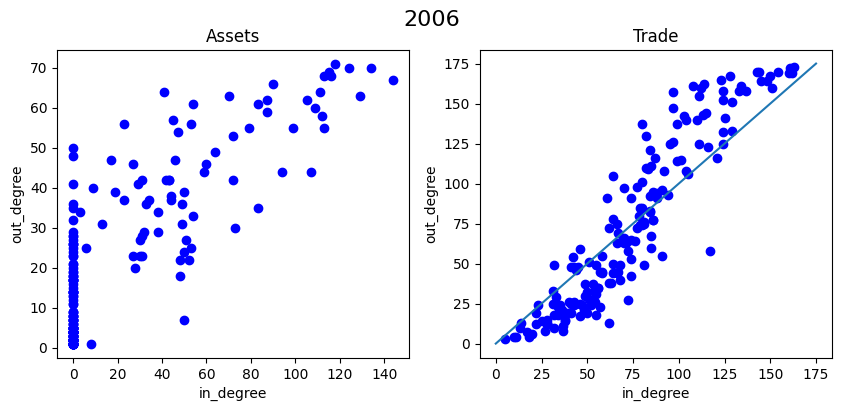

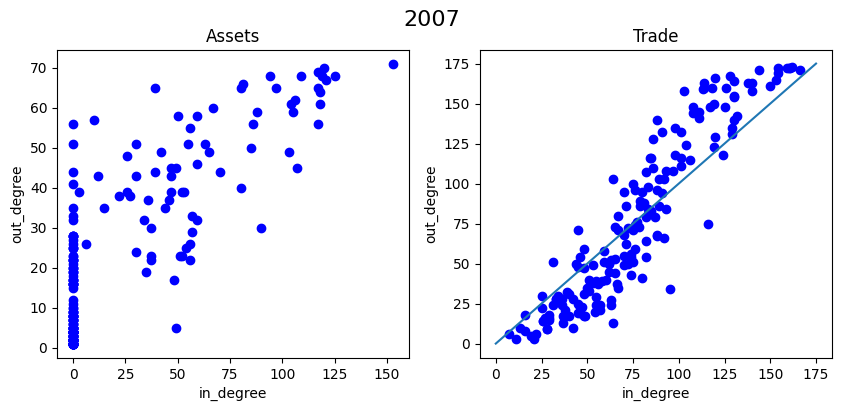

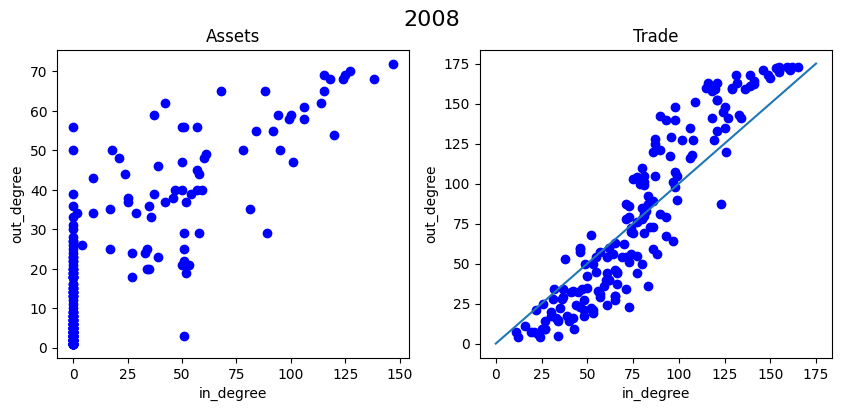

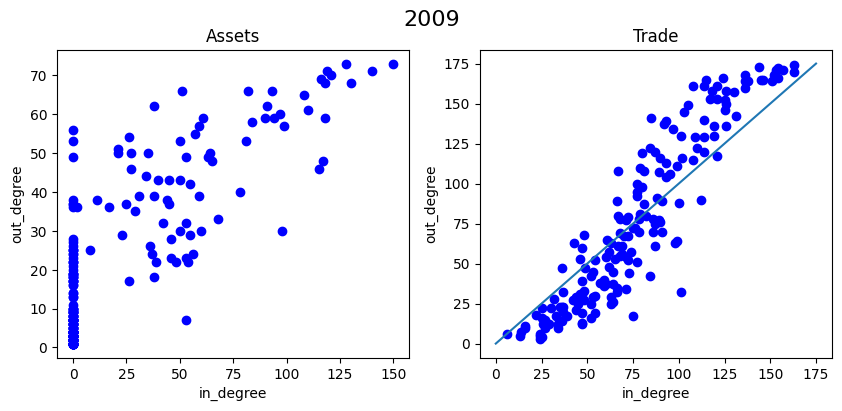

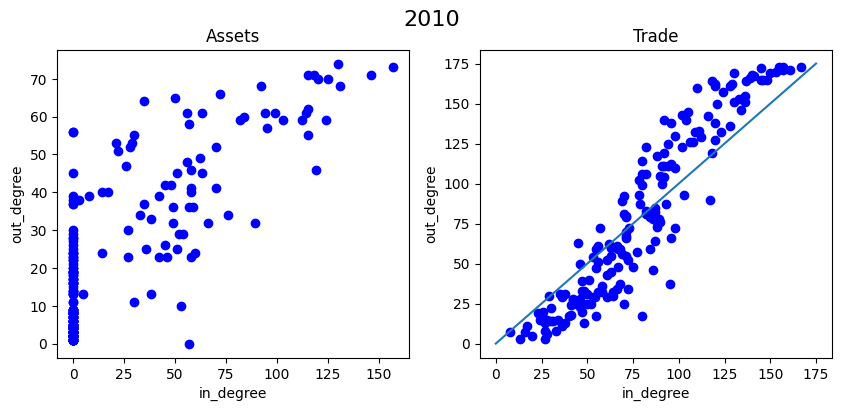

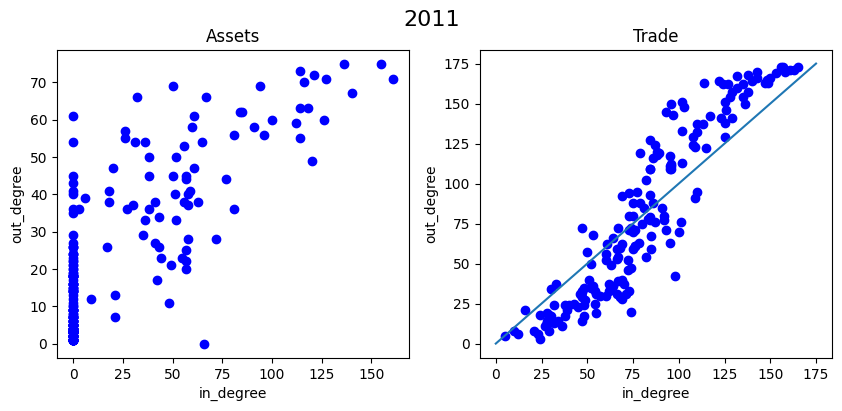

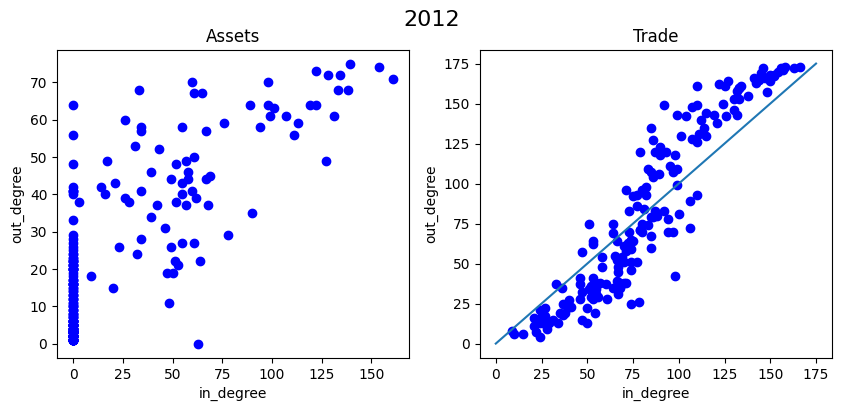

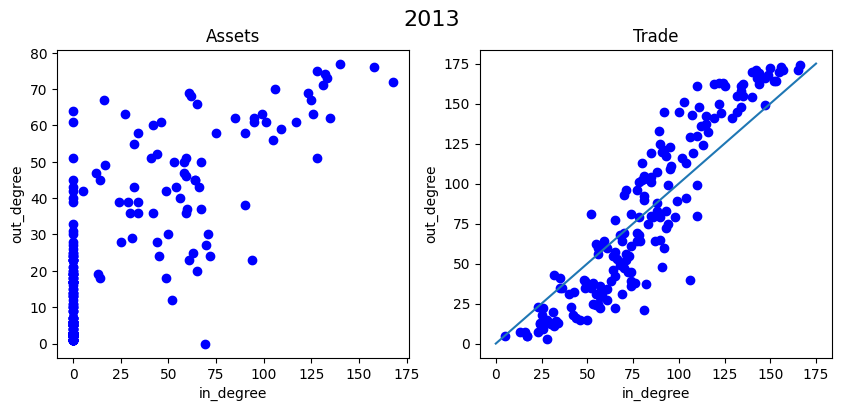

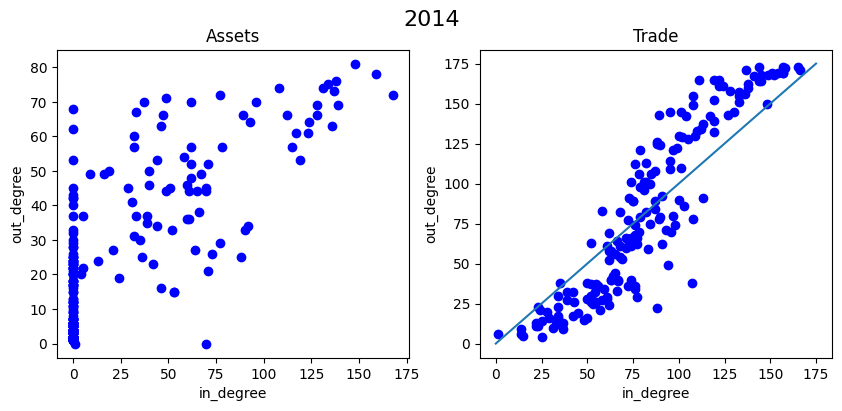

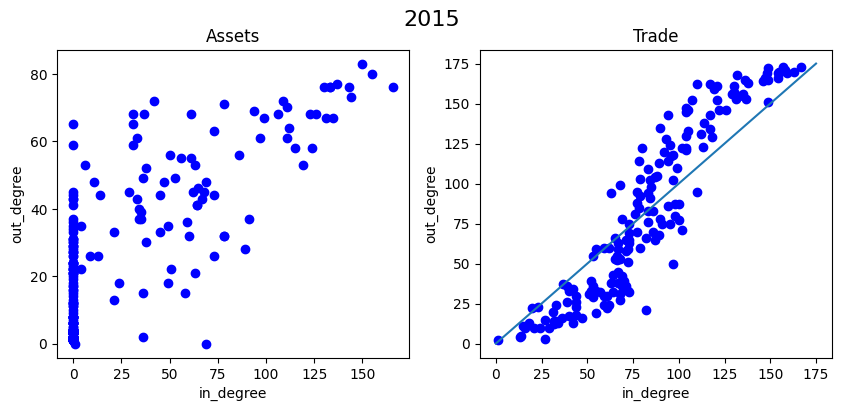

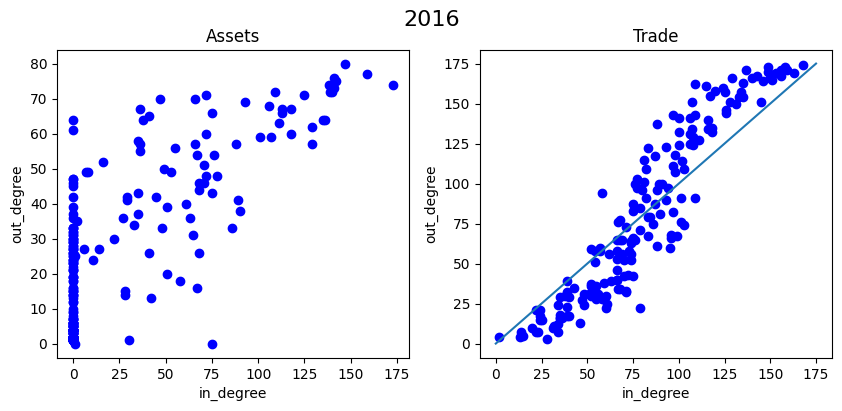

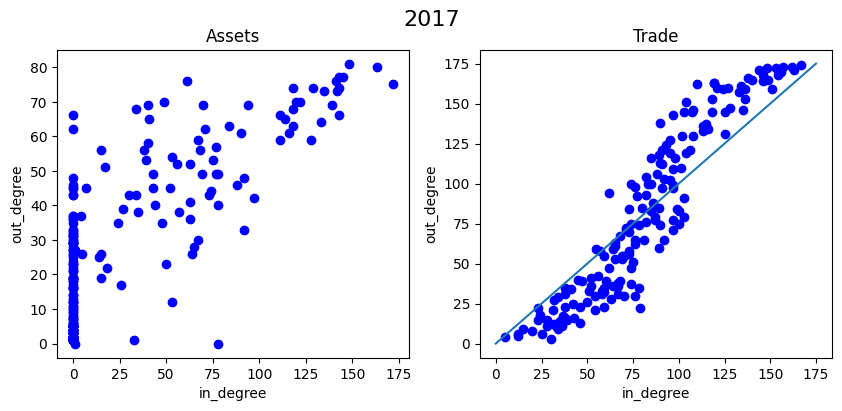

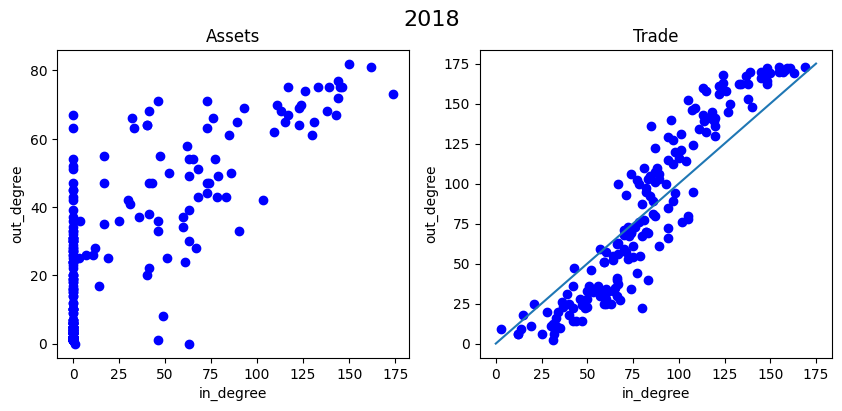

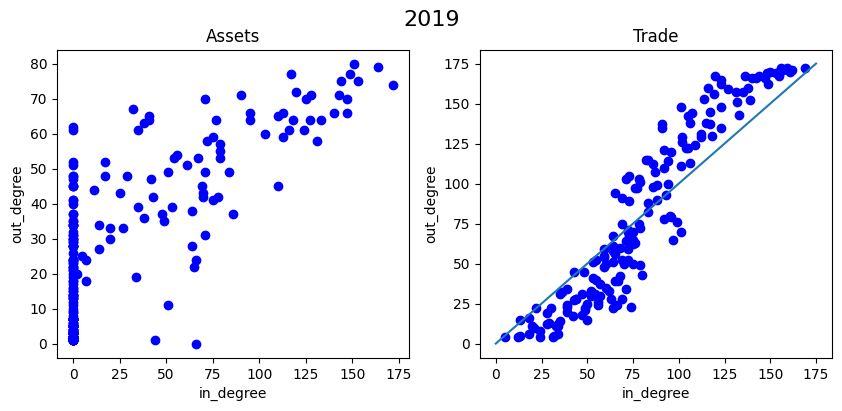

In [190]:
for year in range(2001,2020):
    inoutscatter(year)